# Intelligent Patient Risk Assessment System - Milestone 1

## Project Overview
This notebook implements a Machine Learning-based healthcare analytics system to predict patient health risks using structured clinical data.

**Milestone 1 Objectives:**
1.  **Data Generation**: Create a synthetic dataset simulating patient health records.
2.  **Data Preprocessing & EDA**: Clean, explore, and visualize the data.
3.  **Model Training**: Train Logistic Regression (Classification) and Linear Regression (Risk Scoring).
4.  **Evaluation**: Assess model performance using standard metrics.
5.  **Interactive UI**: A simple interface to input patient data and get real-time risk predictions.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score
import ipywidgets as widgets
from IPython.display import display

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Generation Module

We generate a synthetic dataset of **2000 patients** to simulate real-world health records. The features include:
- **Demographics**: Age, Gender
- **Vitals**: Blood Pressure (Systolic/Diastolic), BMI
- **Lab Values**: Cholesterol, Glucose
- **History**: Smoking, Diabetes, Family History
- **Targets**: `Risk_Score` (0-100) and `Risk_Level` (Low/Medium/High)

In [11]:
def generate_patient_data(num_samples=2000):
    """
    Generates a synthetic dataset for patient risk assessment.
    """
    data = {
        'Age': np.random.randint(20, 90, num_samples),
        'Gender': np.random.choice(['Male', 'Female'], num_samples),
        'BMI': np.random.normal(27, 6, num_samples).round(1),
        'Systolic_BP': np.random.normal(125, 20, num_samples).astype(int),
        'Diastolic_BP': np.random.normal(80, 12, num_samples).astype(int),
        'Cholesterol_Total': np.random.normal(200, 40, num_samples).astype(int),
        'Glucose': np.random.normal(100, 30, num_samples).astype(int),
        'Smoker': np.random.choice([0, 1], num_samples, p=[0.8, 0.2]),  # 0: No, 1: Yes
        'Family_History': np.random.choice([0, 1], num_samples, p=[0.7, 0.3]), # 0: No, 1: Yes
        'Diabetes': np.random.choice([0, 1], num_samples, p=[0.85, 0.15]) # 0: No, 1: Yes
    }

    df = pd.DataFrame(data)

    # Calculate Synthetic Risk Score (Logic-based for realism)
    # Base Risk Formula
    risk_score = (
        (df['Age'] / 90) * 30 +  
        (df['BMI'] / 40) * 20 + 
        (df['Systolic_BP'] / 180) * 15 +
        (df['Cholesterol_Total'] / 300) * 10 +
        (df['Glucose'] / 200) * 10 +
        (df['Smoker'] * 10) +
        (df['Diabetes'] * 5) +
        (df['Family_History'] * 5)
    )

    # Normalize Risk Score to 0-100 scale
    df['Risk_Score'] = ((risk_score - risk_score.min()) / (risk_score.max() - risk_score.min()) * 100).round(1)

    # Assign Risk Levels based on Score thresholds
    conditions = [
        (df['Risk_Score'] < 40),
        (df['Risk_Score'] >= 40) & (df['Risk_Score'] < 70),
        (df['Risk_Score'] >= 70)
    ]
    choices = ['Low', 'Medium', 'High']
    # Fix for TypeError: default must be same type as choices (string)
    df['Risk_Level'] = np.select(conditions, choices, default='Unknown')

    return df

# Generate and display data snapshot
df_patients = generate_patient_data(2000)
print("Sample of Generated Patient Data:")
display(df_patients.head())
print("\nDataset Statistics:")
display(df_patients.describe())

Sample of Generated Patient Data:


,Age,Gender,BMI,Systolic_BP,Diastolic_BP,Cholesterol_Total,Glucose,Smoker,Family_History,Diabetes,Risk_Score,Risk_Level
0,71,Male,28.0,92,58,187,113,0,1,0,52.7,Medium
1,34,Male,27.2,137,61,189,151,1,1,0,58.4,Medium
2,80,Female,30.3,111,73,283,70,0,1,1,75.3,High
3,40,Male,23.5,93,75,223,70,1,0,0,36.5,Low
4,43,Female,27.2,109,62,174,75,0,0,0,22.7,Low



Dataset Statistics:


,Age,BMI,Systolic_BP,Diastolic_BP,Cholesterol_Total,Glucose,Smoker,Family_History,Diabetes,Risk_Score
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.00000,2000.00000
mean,53.851500,26.971650,123.789000,79.117500,199.835000,99.087000,0.201500,0.3195,0.15050,44.09745
std,20.305778,5.905352,20.329071,12.291999,40.031725,30.358034,0.401221,0.4664,0.35765,17.76547
min,20.000000,6.200000,53.000000,39.000000,74.000000,-12.000000,0.000000,0.0000,0.00000,0.00000
25%,36.000000,22.900000,110.000000,71.000000,173.000000,79.000000,0.000000,0.0000,0.00000,31.30000
50%,54.000000,26.900000,124.000000,79.000000,199.000000,99.000000,0.000000,0.0000,0.00000,43.25000
75%,71.000000,31.125000,137.000000,88.000000,227.000000,119.250000,0.000000,1.0000,0.00000,56.82500
max,89.000000,45.400000,189.000000,119.000000,341.000000,193.000000,1.000000,1.0000,1.00000,100.00000


## 2. Data Preprocessing & Exploratory Data Analysis (EDA)

Here we prepare the data for our machine learning models:
1.  **Missing Values Check**: Verify data completeness.
2.  **Encoding**: Convert `Gender` and `Risk_Level` to numerical format.
3.  **Feature Scaling**: Standardize numerical features (Age, BMI, etc.) so they contribute equally to the model.
4.  **Visualizations**: Analyze correlations and class balance.

Missing Values:
 Age                  0
Gender               0
BMI                  0
Systolic_BP          0
Diastolic_BP         0
Cholesterol_Total    0
Glucose              0
Smoker               0
Family_History       0
Diabetes             0
Risk_Score           0
Risk_Level           0
dtype: int64

Risk Level Classes: ['High' 'Low' 'Medium']

Processed Data Sample (Scaled & Encoded):


,Age,BMI,Systolic_BP,Diastolic_BP,Cholesterol_Total,Glucose,Smoker,Family_History,Diabetes,Risk_Score,Risk_Level,Risk_Level_Encoded,Gender_Male
0,0.844725,0.174182,-1.564112,-1.718417,-0.320701,0.458412,0,1,0,52.7,Medium,2,True
1,-0.977873,0.038678,0.650020,-1.474295,-0.270728,1.710453,1,1,0,58.4,Medium,2,True
2,1.288059,0.563757,-0.629256,-0.497806,2.077997,-0.958371,0,1,1,75.3,High,0,False
3,-0.682316,-0.588029,-1.514909,-0.335058,0.578811,-0.958371,1,0,0,36.5,Low,1,True
4,-0.534538,0.038678,-0.727662,-1.392921,-0.645525,-0.793629,0,0,0,22.7,Low,1,False


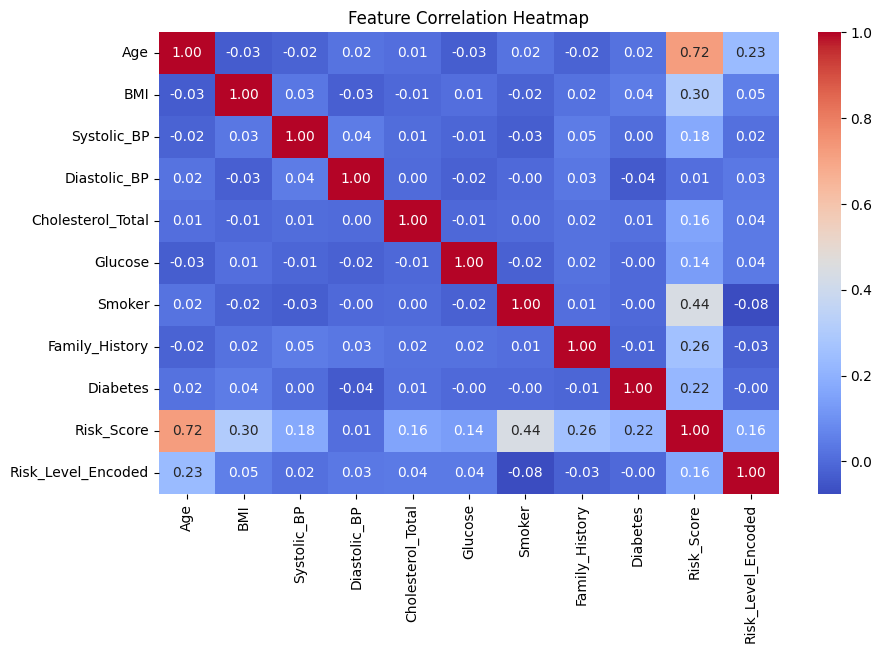

/tmp/ipython-input-1943612334.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk_Level', data=df_patients, order=['Low', 'Medium', 'High'], palette='viridis')


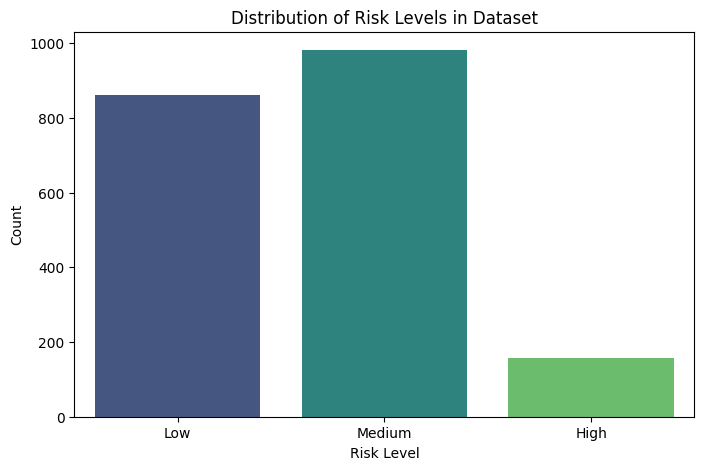

In [12]:
# --- Preprocessing ---

# 1. Check for missing values
print("Missing Values:\n", df_patients.isnull().sum())

# 2. Encoding
# Label Encoding for Target (Risk Level) -> 0: High, 1: Low, 2: Medium (order depends on alphabetical, we'll check classes)
le_risk = LabelEncoder()
df_patients['Risk_Level_Encoded'] = le_risk.fit_transform(df_patients['Risk_Level'])
print("\nRisk Level Classes:", le_risk.classes_)

# One-Hot Encoding for Gender (Male=1, Female=0 handling via drop_first)
# Check if column exists first to allow re-running cell without error
if 'Gender' in df_patients.columns:
    df_patients = pd.get_dummies(df_patients, columns=['Gender'], drop_first=True)

# 3. Feature Scaling
scaler = StandardScaler()
numerical_cols = ['Age', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Total', 'Glucose']
df_patients[numerical_cols] = scaler.fit_transform(df_patients[numerical_cols])

# Display processed dataframe sample
print("\nProcessed Data Sample (Scaled & Encoded):")
display(df_patients.head())

# --- EDA (Exploratory Data Analysis) ---

# Correlation Heatmap
plt.figure(figsize=(10, 6))
numeric_df = df_patients.select_dtypes(include=[np.number]) # Fix: Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Risk Level Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Risk_Level', data=df_patients, order=['Low', 'Medium', 'High'], palette='viridis')
plt.title("Distribution of Risk Levels in Dataset")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()

## 3. Model Training & Evaluation

We use two supervised learning models:
1.  **Logistic Regression**: Classifies patients into `Low`, `Medium`, or `High` risk.
2.  **Linear Regression**: Predicts the exact `Risk_Score` (0-100).

**Evaluation Metrics:**
- **Accuracy, Precision, Recall, F1-Score** (for Classification)
- **Mean Squared Error (MSE), R2 Score** (for Regression)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- Classification Model (Logistic Regression) Performance ---
Accuracy: 0.9825
Precision (Weighted): 0.9829
Recall (Weighted): 0.9825
F1 Score (Weighted): 0.9822


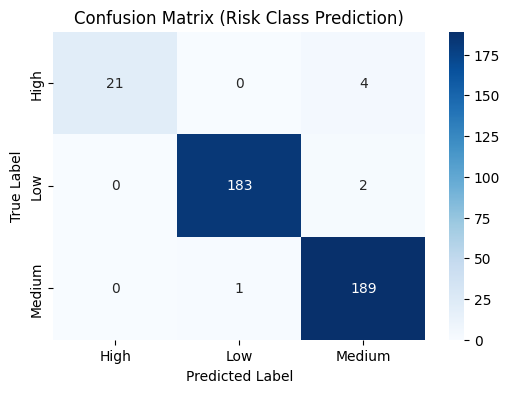


--- Regression Model (Linear Regression) Performance ---
Mean Squared Error (MSE): 0.0008
R-squared (R2) Score: 1.0000


/tmp/ipython-input-4105806752.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


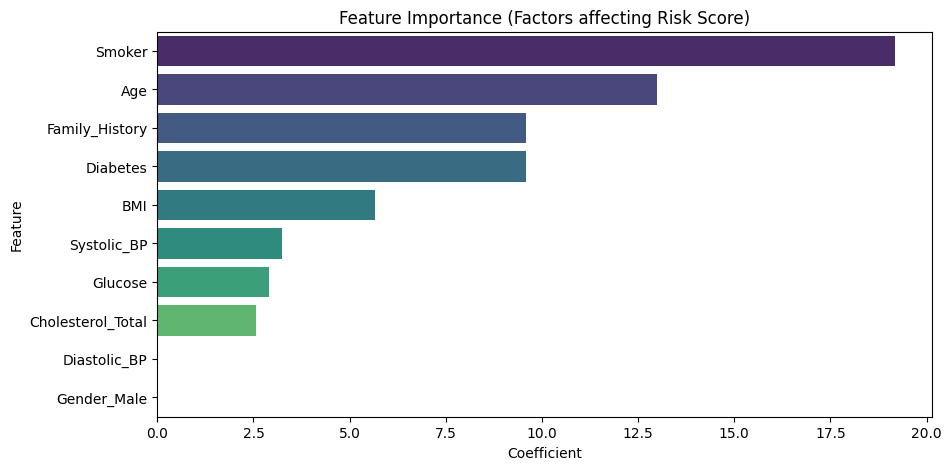

In [13]:
# Define Features (X) and Targets (y)
X = df_patients.drop(['Risk_Score', 'Risk_Level', 'Risk_Level_Encoded'], axis=1)
y_class = df_patients['Risk_Level_Encoded'] # Target for Classification
y_reg = df_patients['Risk_Score'] # Target for Regression

# Split Data (80% Train, 20% Test)
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)

# --- Model 1: Logistic Regression (Classification) ---
clf_model = LogisticRegression(multi_class='multinomial', max_iter=1000)
clf_model.fit(X_train, y_class_train)
y_class_pred = clf_model.predict(X_test)

# Evaluation - Classification
print("--- Classification Model (Logistic Regression) Performance ---")
print(f"Accuracy: {accuracy_score(y_class_test, y_class_pred):.4f}")
print(f"Precision (Weighted): {precision_score(y_class_test, y_class_pred, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_class_test, y_class_pred, average='weighted'):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_class_test, y_class_pred, average='weighted'):.4f}")

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_class_test, y_class_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_risk.classes_, yticklabels=le_risk.classes_)
plt.title("Confusion Matrix (Risk Class Prediction)")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# --- Model 2: Linear Regression (Risk Scoring) ---
reg_model = LinearRegression()
reg_model.fit(X_train, y_reg_train)
y_reg_pred = reg_model.predict(X_test)

# Evaluation - Regression
print("\n--- Regression Model (Linear Regression) Performance ---")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_reg_test, y_reg_pred):.4f}")
print(f"R-squared (R2) Score: {r2_score(y_reg_test, y_reg_pred):.4f}")

# Feature Importance Plot
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': reg_model.coef_})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance (Factors affecting Risk Score)")
plt.show()

## 4. Interactive Patient Evaluation UI

This section provides a user-friendly form to input new patient data and receive an instant risk assessment from our trained models.

In [ ]:
# UI Setup using ipywidgets
style = {'description_width': 'initial'}

# Input Widgets
w_age = widgets.IntSlider(value=45, min=20, max=90, description='Age:', style=style)
w_gender = widgets.Dropdown(options=['Male', 'Female'], value='Male', description='Gender:', style=style)
w_bmi = widgets.FloatSlider(value=25.0, min=15.0, max=45.0, step=0.1, description='BMI:', style=style)
w_bp_sys = widgets.IntSlider(value=120, min=90, max=180, description='Systolic BP:', style=style)
w_bp_dia = widgets.IntSlider(value=80, min=60, max=120, description='Diastolic BP:', style=style)
w_chol = widgets.IntSlider(value=200, min=100, max=350, description='Cholesterol:', style=style)
w_glu = widgets.IntSlider(value=100, min=70, max=250, description='Glucose:', style=style)
w_smoker = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Smoker:', style=style)
w_fam_hist = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Family History:', style=style)
w_diabetes = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Diabetes:', style=style)

btn_predict = widgets.Button(description="Predict Risk", button_style='success', icon='check')
out_result = widgets.Output()

def on_predict_click(b):
    with out_result:
        out_result.clear_output()
        
        # Construct Input Data
        input_data = pd.DataFrame({
            'Age': [w_age.value],
            'BMI': [w_bmi.value],
            'Systolic_BP': [w_bp_sys.value],
            'Diastolic_BP': [w_bp_dia.value],
            'Cholesterol_Total': [w_chol.value],
            'Glucose': [w_glu.value],
            'Smoker': [w_smoker.value],
            'Family_History': [w_fam_hist.value],
            'Diabetes': [w_diabetes.value],
            'Gender_Male': [1 if w_gender.value == 'Male' else 0]
        })
        
        # Align columns with training data
        input_data = input_data[X.columns]
        
        # Scale Input Data (Using the scaler fitted on training data)
        input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])
        
        # Predictions
        pred_class_encoded = clf_model.predict(input_data)[0]
        pred_class_label = le_risk.inverse_transform([pred_class_encoded])[0]
        pred_probs = clf_model.predict_proba(input_data)[0]
        pred_score = reg_model.predict(input_data)[0]
        
        # Display Results
        display(widgets.HTML(f"<h3>Risk Analysis Result</h3>"))
        print(f"Predicted Risk Score: {pred_score:.1f} / 100")
        print(f"Risk Category: {pred_class_label}")
        print(f"Model Confidence: {max(pred_probs)*100:.1f}%")
        
        # Dynamic Advice
        if pred_score > 70:
            display(widgets.HTML("<b style='color:red'>⚠️ High Risk Detected! Please consult a healthcare professional immediately.</b>"))
        elif pred_score > 40:
            display(widgets.HTML("<b style='color:orange'>⚠️ Moderate Risk. Consider lifestyle improvements (diet, exercise).</b>"))
        else:
            display(widgets.HTML("<b style='color:green'>✅ Low Risk. Maintain your healthy habits!</b>"))

btn_predict.on_click(on_predict_click)

# Layout
ui = widgets.VBox([
    widgets.HTML("<h3>Patient Vitals Input</h3>"),
    widgets.HBox([w_age, w_gender]),
    widgets.HBox([w_bmi, w_smoker]),
    widgets.HBox([w_bp_sys, w_bp_dia]),
    widgets.HBox([w_chol, w_glu]),
    widgets.HBox([w_fam_hist, w_diabetes]),
    widgets.Box([btn_predict], layout=widgets.Layout(margin='20px 0px 0px 0px')),
    out_result
])

display(ui)